# Advanced Out-of-Distribution Detection for Multi-Class Classification

**Final Project for the Course Computer Vision tought at La Sapienza 2025**  
Name: Janne Rotter  
Matricula: 2223529  
Email: rotter.2223529@studenti.uniroma1.it


Notes: This project will focus on post-hoc anaysis.


# Imports

Here all necessary librarys for the projects are imported

In [1]:
#Necessary library imports
import os
import requests
import tarfile
import time
import random
import shutil
from tqdm import tqdm
import urllib.request
import copy
import math

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import numpy as np
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
import pandas as pd


from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
import tensorflow as tf

# Globals

Definition of global variables. Note that one could argue that transform could also be moved here. However I think it fits thematicaly better in the data preprocessing section.

In [2]:
train_batch_size = 32
test_batch_size = 1 #some OOD methods (eg ODIN) require batch size of 1
num_epochs = 5 #choosen according to paper by . Also trade-off since only little computational ressources were available

#set a seed for reproducability
random.seed(42)

## Hardware check
We check wheter we are able to use a GPU as this would significantly improve learning time and set the global device variable accordingly. Note that this code was taken from the Tutorial Session 3 on DL.

In [3]:
#get wheter gpu is available --> CODE TAKEN FROM Tutorial-Session
def hardware_check():
    # Check if GPU is available and return the device
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"GPU is available!")
        print(f"  -> GPU - {torch.cuda.get_device_name()}")
        print(f"  -> Total Memory: {torch.cuda.get_device_properties(device).total_memory / 1024**3:.2f} GB")
    else:
        device = torch.device("cpu")
        print("GPU is not available, using CPU.")
        print("\nCPU Information:")

        # Fix the backslash issue in the command string by escaping it
        cpu_model = os.popen("cat /proc/cpuinfo | grep \"model name\" | uniq").read().strip()
        print(f"CPU Model: {cpu_model}")
        print(f"Number of CPU cores: {os.cpu_count()}")

    return device

device = hardware_check()
print(f"\nUsing {device} for computation")

GPU is available!
  -> GPU - Tesla T4
  -> Total Memory: 14.74 GB

Using cuda for computation


#Utils

Functions that are used throughout the code

### Helper function to visualize the file sturcutre

In [4]:
#Helper function to visualize the file structures
def print_directory_tree(startpath, max_depth=3):
  for root, dirs, files in os.walk(startpath):

    #limit depth and break out of loop
    depth = root[len(startpath):].count("/")
    if depth > max_depth:
      #break
      continue

    #Define indentation depth
    indent = " " * 2 * depth
    print(f"{indent}{os.path.basename(root)}/")
    subindent = " " * 2 * (depth + 1)

    #if no subdirectories, only print first 3 files
    if not dirs:
      for f in files[:3]:
        print(f"{subindent}{f}")
    else:
      for f in files:
        print(f"{subindent}{f}")

# Data

Everything related to data download and preprocessing.


In [5]:
#remove unnesecary data that is preimported to google colab
!rm -rf sample_data

## Dataset Downloads

This is the first step in our data handling pipeline as we need to download the **In-Distribution Data (ID-Data)** as well as the **Out-of-Distribution Data (OOD-Data)**. In some cases we also need to **reorganize** them in such a way that we can efficiently use them to train our model.

Generally we use:
* [Food-101 dataset](https://www.tensorflow.org/datasets/catalog/food101) (ID data)
* [SVHN dataset](http://ufldl.stanford.edu/housenumbers/) (OOD data)
* [Texture DTD dataset](https://www.tensorflow.org/datasets/catalog/dtd) (OOD data)
* [Place365 dataset](https://www.tensorflow.org/datasets/catalog/places365_small) (OOD data)

Note that all of these datasets are described in more detail in the following.

### Download and extract the Food-101 dataset

The Food-101 dataset is a large-scale real-world image dataset for food classification. Generally it consists of 101 different classes with 1000 images each, totaling 101,000 images.

In [6]:
#Helper function for food dataset
def get_food_data_extract():

  #downlaod the Food-101 dataset
  #check if the directory exists
  if not os.path.exists("food-101"):
    print("Beginning download of Food-101 Dataset")

    #create the directory
    os.makedirs("food-101")

    #download the dataset
    response = requests.get('http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz', stream=True)

    #save the downloaded file
    file_path = os.path.join("food-101", 'food-101.tar.gz')
    with open(file_path, 'wb') as file:
      #write in chunks
      for chunk in response.iter_content(chunk_size=1024):
        if chunk:
          file.write(chunk)

    print("Beginning extraction of the Food-101 Dataset")

    #extract the contents
    with tarfile.open(file_path, 'r:gz') as tar:
      tar.extractall("food-101")

    print("Food-101 dataset downloaded and extracted")

    #view structure
    print("\n Food-101 Directory Structure:")
    print_directory_tree("food-101", max_depth=1)

  else:
    print("Food-101 dataset already exists.")

get_food_data_extract()

Beginning download of Food-101 Dataset
Beginning extraction of the Food-101 Dataset
Food-101 dataset downloaded and extracted

 Food-101 Directory Structure:
food-101/
  food-101.tar.gz
  food-101/
    README.txt
    license_agreement.txt


### Reorganize the Food-101 Dataset
We do this, as it allows us to efficiently load it using a DataLoader

In [7]:
#Helper function to copy images
def copy_images(source_dir, filenames, destination_dir):
  for filename in tqdm(filenames, desc=f"Copying images to {destination_dir}"):
    src_path = os.path.join(source_dir, filename)
    dest_path = os.path.join(destination_dir, filename)
    shutil.copy2(src_path, dest_path)


#reorganize the content such that we can later use dataloader
def reorganize_data():
  base_dir = "food-101" #base directory and output directory should be the same
  images_dir = os.path.join("food-101", os.path.join(base_dir, "images"))

  test_ratio = 0.2  #80% train, 20% test

  #create the new structure directly inside 'food-101'
  train_dir = os.path.join(base_dir, "train")
  test_dir = os.path.join(base_dir, "test")
  os.makedirs(train_dir, exist_ok=True)
  os.makedirs(test_dir, exist_ok=True)

  #loop through each class in the images directory
  for class_name in os.listdir(images_dir):
    class_path = os.path.join(images_dir, class_name)

    #get all image filenames for this class
    filenames = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

    #shuffle the filenames randomly
    random.shuffle(filenames)

    #split the filenames into train and test
    split_index = int(len(filenames) * (1 - test_ratio))  #80% for training
    train_files = filenames[:split_index]
    test_files = filenames[split_index:]

    #create class directories in the train and test directories
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    #copy the images to the appropriate train/test folders
    copy_images(class_path, train_files, os.path.join(train_dir, class_name))
    copy_images(class_path, test_files, os.path.join(test_dir, class_name))

  #after copying, delete unnecessary directories like food-101 and the tar file
  shutil.rmtree(os.path.join("food-101", "food-101"))
  os.remove(os.path.join("food-101", "food-101.tar.gz"))

  print("Food-101 Directory Structure:")
  print_directory_tree("food-101", max_depth=1)

reorganize_data()
print("Dataset split into train and test sets and extraneous folders removed.")

Copying images to food-101/test/guacamole: 100%|██████████| 200/200 [00:00<00:00, 1326.35it/s]
Copying images to food-101/train/chicken_quesadilla: 100%|██████████| 800/800 [00:00<00:00, 838.71it/s] 
Copying images to food-101/test/chicken_quesadilla: 100%|██████████| 200/200 [00:00<00:00, 3560.20it/s]
Copying images to food-101/test/tacos: 100%|██████████| 200/200 [00:00<00:00, 2419.56it/s]
Copying images to food-101/train/macaroni_and_cheese: 100%|██████████| 800/800 [00:00<00:00, 7558.96it/s]
Copying images to food-101/test/macaroni_and_cheese: 100%|██████████| 200/200 [00:00<00:00, 7778.90it/s]
Copying images to food-101/test/caesar_salad: 100%|██████████| 200/200 [00:00<00:00, 1746.38it/s]
Copying images to food-101/train/hot_and_sour_soup: 100%|██████████| 800/800 [00:00<00:00, 4985.59it/s]
Copying images to food-101/test/hot_and_sour_soup: 100%|██████████| 200/200 [00:00<00:00, 5010.40it/s]
Copying images to food-101/test/beignets: 100%|██████████| 200/200 [00:00<00:00, 1278.71i

Food-101 Directory Structure:
food-101/
  test/
  train/
Dataset split into train and test sets and extraneous folders removed.


### Download and resturcutre the SVHN dataset

The **Street View House Numbers (SVHN)** dataset is a real-world image dataset for digit recognition. It contains over 600,000 images of cropped images taken from house numbers.

In [8]:
#Helper function for svhn extract
def get_svhn_data_extract(save_dir="svhn"):

  #Helper function needed for extraction since train and test data is donwloaded seperatly as mat
  def extract_images(mat_path, prefix, start_idx=0):
      mat = scipy.io.loadmat(mat_path)
      images = mat['X']  #image shape [32, 32, 3, N]
      num_images = images.shape[3]
      print(f"Extracting {num_images} images from {os.path.basename(mat_path)}")

      #extract all the images
      for i in range(num_images):
          img_array = images[:, :, :, i]
          img = Image.fromarray(np.transpose(img_array, (1, 0, 2)))  #H x W x C
          img_name = f"{prefix}_{i + start_idx + 1:05d}.png"
          img.save(os.path.join(save_dir, img_name))

      return num_images #we need to keep track of the current index for the naming of the .png files

  #check if the directory exists
  if not os.path.exists(save_dir):
    print("Beginning download of SVHN Dataset")

    #create Directory
    os.makedirs(save_dir, exist_ok=True)

    urls = {"train": "http://ufldl.stanford.edu/housenumbers/train_32x32.mat", "test": "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"}

    #download files --> done twice, once for train and once for test
    for name, url in urls.items():
      file_path = os.path.join(save_dir, f"{name}_32x32.mat")
      if not os.path.exists(file_path):
        print(f"Downloading {name} data...")
        response = requests.get(url, stream=True)
        with open(file_path, "wb") as f:
          #again write down in chunks
          for chunk in response.iter_content(chunk_size=1024):
            if chunk:
              f.write(chunk)
        print(f"{name} data downloaded.")
    else:
        print(f"{name} data already exists.")


    #extract train and test data
    idx = 0
    idx += extract_images(os.path.join(save_dir, "train_32x32.mat"), "svhn", idx)
    idx += extract_images(os.path.join(save_dir, "test_32x32.mat"), "svhn", idx)

    print(f"Done. All images saved in: {save_dir}")
    print(f"Total number of images in dataset: {idx}")

  else:
    print("SVHN dataset already exists.")

get_svhn_data_extract()

Beginning download of SVHN Dataset
train data downloaded.
test data downloaded.
test data already exists.
Extracting 73257 images from train_32x32.mat
Extracting 26032 images from test_32x32.mat
Done. All images saved in: svhn
Total number of images in dataset: 99289


### Donwload and resturcture the DTD (Textures) and LSUN Dataset

The datasets include **images of textures** and **places** respectivly. The reason to opt for the textures dataset was that it offers little object structure, so something **sematicly completly different** than the Food-101 dataset. The Place365 dataset has the upside of possesing a **high visual dissimilarity** to food while still including realistic natural images.

Both datasets are also wiedly used for OOD Detection experimentation e.g. by [Tang et al. (2024)](https://openaccess.thecvf.com/content/CVPR2024/papers/Tang_CORES_Convolutional_Response-based_Score_for_Out-of-distribution_Detection_CVPR_2024_paper.pdf) or [Liu et al. (2020)](https://proceedings.neurips.cc/paper/2020/file/f5496252609c43eb8a3d147ab9b9c006-Paper.pdf). For the reminder of this notebook please consider that not all datasets have the same number of images.

In [9]:
def get_dtd_images_extract(save_dir='textures'):

  #check if directory already exists
  if not os.path.exists(save_dir):

    #create directory
    os.makedirs(save_dir, exist_ok=True)

    #we want to download the whole dataset (train, test, val) so we have more data
    splits = ['train', 'val', 'test']
    total_saved = 0

    #iterate over all splits
    for split in splits:

      #download and extract split
      dtd = torchvision.datasets.DTD(root='./data', split=split, download=True)
      for i in range(len(dtd)):
        img, _ = dtd[i]
        img.save(os.path.join(save_dir, f'dtd_{total_saved:05d}.jpg'))
        total_saved += 1

    #remove downloaded (unstructured data)
    !rm -rf data

    print(f"Saved {total_saved} DTD images to {save_dir}/")
  else:
    print(f"Directory {save_dir} already exists")

get_dtd_images_extract()


100%|██████████| 625M/625M [00:23<00:00, 26.5MB/s]


Saved 5640 DTD images to textures/


In [10]:
def get_places365_images_extract(save_dir='place365'):

  #check if directory already exists
  if not os.path.exists(save_dir):

    #create directory
    os.makedirs(save_dir, exist_ok=True)

    #downlaod the dataset
    places = torchvision.datasets.Places365(
        #we download only the validation part as it already contains eneugh images
        root='./data', split='val', download=True
    )

    #iterate over the DS
    for i in range( len(places)):
        img, _ = places[i]  #img is a PIL Image
        img.save(os.path.join(save_dir, f'places_{i:05d}.jpg'))

    #remove downloaded (unstructured data)
    !rm -rf data

    print(f"Saved {len(places)} place images to {save_dir}/")
  else:
    print(f"Directory {save_dir} already exists")

get_places365_images_extract()

100%|██████████| 67.5M/67.5M [00:01<00:00, 39.9MB/s]
100%|██████████| 2.27G/2.27G [00:46<00:00, 49.3MB/s]


Saved 36500 place images to place365/


## Data Preprocessing
Includs data loading and augmentation

### Visualization of some example images

This step is usefull to get a **first overview** over the data at hand. For example here we can see that not all images have the same size. Thus we need to resize them later.

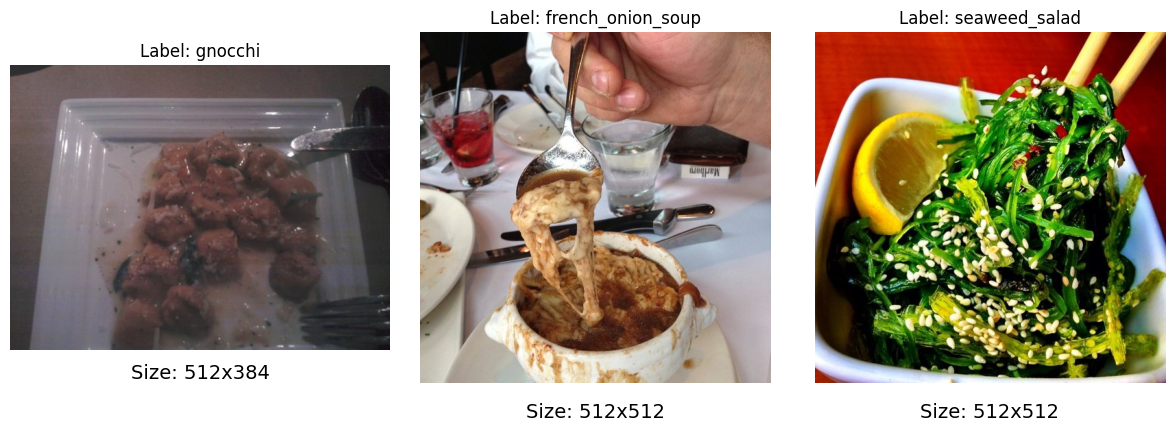

In [11]:
#path to image
image_root = "food-101/train"

#walk through all subfolders and gather all images
image_paths = []
for root, dirs, files in os.walk(image_root):
  for file in files:
    full_path = os.path.join(root, file)
    #need relative paths for visualization
    rel_path = os.path.relpath(full_path, image_root)
    image_paths.append(rel_path)

#pick 3 random image paths
sampled_paths = random.sample(image_paths, 3)

#display the images with labels
plt.figure(figsize=(12, 4))
#iterate over the 3 random images
for idx, path in enumerate(sampled_paths):
  class_name = path.split('/')[0]
  full_img_path = os.path.join(image_root, path)
  image = Image.open(full_img_path)
  img_size = image.size

  #plot each of them
  plt.subplot(1, 3, idx + 1)
  plt.imshow(image)
  plt.title(f"Label: {class_name}")
  plt.text(0.5, -0.1, f"Size: {img_size[0]}x{img_size[1]}",
         fontsize=14, ha='center', transform=plt.gca().transAxes) #
  plt.axis('off')

#save the figure
plt.savefig("id_data_examples.png", dpi=250)

plt.tight_layout()
plt.show()

### Data Transformation
In this step we transform the data so that they are **homogenous in size and datatype (Tensor)**. Additionally, we also **normalize** the data with the typical image net means and std (https://pytorch.org/vision/stable/models.html) to make training faster and more stable.

Note that i choose not to individually calculate the exact means and stds as the images in the Food-101 Dataset are fairly standard and we rely on a pretrained Imagenet model (because of computational efficiency).

In [12]:
#define transforms (resize, normalize, etc.)
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resize such that all images have same size
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  #typical ImageNet means (as used in the tutorial session)
        std=[0.229, 0.224, 0.225]
    )
])

### Data Augmentation

The goal of this step is to augment the data randomly to **achieve higher robustness and generalization**. This  is essential as it artificially expands the dataset and simulates real-world variations, such as different viewpoints or lighting conditions. The general structure of this code was taken from the third lab session on DL.

In [13]:
def apply_random_augmentation(sample, aug_prob=0.5):

  # 1. Random Horizontal Flip
  if random.random() < aug_prob:
    sample = transforms.functional.hflip(sample)

  # 2. Random Crop (with probability)
  if random.random() < aug_prob:
    # Get original dimensions
    h, w = sample.shape[1:3]

    # Determine crop dimensions (between 80-100% of original dimensions)
    new_h = int(h * random.uniform(0.8, 1.0))
    new_w = int(w * random.uniform(0.8, 1.0))

    # Determine crop position
    top = random.randint(0, h - new_h)
    left = random.randint(0, w - new_w)

    # Apply crop
    sample = sample[:, top:top + new_h, left:left + new_w]

    # Resize back to original dimensions
    sample = transforms.functional.resize(sample, (h, w), interpolation=transforms.InterpolationMode.BILINEAR)

  # 3. Random Rotation (small angles)
  if random.random() < aug_prob:
    angle = random.uniform(-15, 15)  # Rotation of ±15 degrees
    sample = transforms.functional.rotate(sample, angle, interpolation=transforms.InterpolationMode.BILINEAR)

  # 4. Random Color Jitter (only for RGB image --> we only have RGB images in our training dataset)
  if random.random() < aug_prob:
    color_jitter = transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    )
    sample = color_jitter(sample)

  # 5. Random Gaussian Noise (only for RGB image --> we only have RGB images in our training dataset)
  if random.random() < aug_prob:
    noise = torch.randn_like(sample) * 0.02  # Adjust standard deviation to control noise intensity
    sample = torch.clamp(sample + noise, 0.0, 1.0)  # Clamp values between 0 and 1

  return sample

### Visualization of originial, transformed and augmented images

This helps to show how an image changes in the data preprocessing pipeline


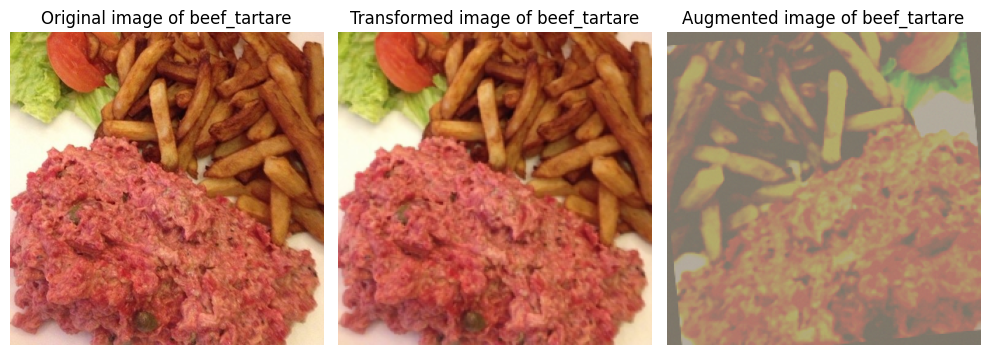

In [14]:
#Helper function to visualize augmented image
def visualize_transformed_augmented(image_path):
  #get the class of the image
  class_name = image_path.split('/')[2]

  original_image = Image.open(image_path).convert("RGB")
  transformed_image = transform(original_image) #get the transformed image
  augmented_image = apply_random_augmentation(transformed_image, aug_prob=1.0) #get the augmented image

  #initilize plt.figure
  plt.figure(figsize=(10, 20))

  #iterate through list of images to visualize
  images = [original_image, transformed_image, augmented_image]
  titles = [f"Original image of {class_name}", f"Transformed image of {class_name}", f"Augmented image of {class_name}"]

  for i, img in enumerate(images):
    plt.subplot(1, 3, i + 1)  # 1 rows, 3 column, i-th subplot
    plt.title(titles[i])
    if isinstance(img, torch.Tensor): #unnormalize if its already a tensor and convert to numpy --> should be the case for transformed and augmented_image
      img = img.permute(1, 2, 0).numpy() #transform to np.array
      img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  #reverse normalization
      img = img.clip(0, 1)
    plt.imshow(img)
    plt.axis("off")

  #save the figure
  plt.savefig("transformed_augmented_images.png", dpi=250)

  plt.tight_layout()
  plt.show()

#Helper function to get a random image path
def get_random_image_id(base_dir):

  #get all files in directory and return a random one
  class_files = [f for f in os.listdir(base_dir)]
  selected_class_file = random.choice(class_files)
  image_files = [f for f in os.listdir(os.path.join(base_dir, selected_class_file))]
  return os.path.join(base_dir, os.path.join(selected_class_file, random.choice(image_files)))

random_image_path = get_random_image_id("food-101/train")

visualize_transformed_augmented(random_image_path)

### Log the training data stats
This is interesting as it allows us to gain an overview over what training data we are actually going to use. Please note that the following two cells are inspired by the lab session on DL.

Note that the file structure of the current food-101 dataset would also allow to load it as a dataset with the dataset.imagefolder. However doing it manually alows to also specify the augmentation pipeline.

In [15]:
class Food101Dataset(Dataset):
  def __init__(self, root_dir, mode='train', transform=None, augment=False, aug_prob=0.5):
    self.root_dir = os.path.join(root_dir, mode)  #depends on the mode (either food-101/train or food-101/test)
    self.transform = transform
    self.augment = augment and mode == 'train'
    self.aug_prob = aug_prob

    #Gather all image paths and labels
    self.image_paths = []
    self.labels = []
    self.class_to_idx = {}

    #Get all classes (in our case structured as folders)
    classes = sorted(os.listdir(self.root_dir))
    for idx, class_name in enumerate(classes):
      class_folder = os.path.join(self.root_dir, class_name)
      if not os.path.isdir(class_folder): #sanity check
        continue
      self.class_to_idx[class_name] = idx
      for img_name in os.listdir(class_folder):
        self.image_paths.append(os.path.join(class_folder, img_name))
        self.labels.append(idx)

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    label = self.labels[idx]

    image = Image.open(image_path).convert('RGB')

    #Apply transforms
    if self.transform:
      image = self.transform(image)

    #Apply augmentation only in training
    if self.augment and random.random() < self.aug_prob:
      image = apply_random_augmentation(image)

    return image, label

In [16]:
#Create the train Dataset
train_dataset = Food101Dataset(
  root_dir="food-101",
  mode='train',
  transform=transform,
  augment=True,
  aug_prob=0.5
)

print(f"\n===================================================\n")
#Log dataset length and augmentation info
print(f"Train dataset size: {train_dataset.__len__()}")
print(f"Augmentation enabled: {train_dataset.augment}")
print(f"Augmentation probability: {train_dataset.aug_prob}")
print(f"\n===================================================\n")

#Create Train DataLoader
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

#Log train dataloader configuration
print(f"Train DataLoader batch size: {train_batch_size}")
print(f"Number of batches per epoch: {len(train_loader)}")

#Create the Test Dataset
test_dataset = Food101Dataset(
  root_dir="food-101",
  mode='test',
  transform=transform,
  augment=False
)

#Example of logging a batch of data
print("\n--- Logging a batch of training data ---")
for i, (images, labels) in enumerate(train_loader):
  if i == 0:  #Log the first batch only
    print(f"Shape of the first batch (image): {images.shape} (Batch size, channels, x-dim, y-dim)")
    print(f"Data type of images: {images.dtype}")
    print(f"Shape of the first batch (labels): {labels.shape}")
    print(f"Data type of labels: {labels.dtype}")
  break  #Exit after the first batch

print(f"\n===================================================\n")
#Log test dataset size and augmentation info
print(f"Test dataset size: {test_dataset.__len__()}")
print(f"Augmentation enabled: {test_dataset.augment}")
print(f"\n===================================================\n")

#create Test DataLoader
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

#Log test dataloader configuration
print(f"Test DataLoader batch size: {test_batch_size}")
print(f"Number of batches per epoch: {len(test_loader)}")

#Example of logging a batch of data
print("\n--- Logging a batch of testing data ---")
for i, (images, labels) in enumerate(test_loader):
  if i == 0:  #log the first batch only
    print(f"Shape of the first batch (image): {images.shape} (Batch size, channels, x-dim, y-dim)")
    print(f"Data type of images: {images.dtype}")
    print(f"Shape of the first batch (labels): {labels.shape}")
    print(f"Data type of labels: {labels.dtype}")
  break  #exit after the first batch

print(f"\n===================================================\n")



Train dataset size: 80800
Augmentation enabled: True
Augmentation probability: 0.5


Train DataLoader batch size: 32
Number of batches per epoch: 2525

--- Logging a batch of training data ---
Shape of the first batch (image): torch.Size([32, 3, 224, 224]) (Batch size, channels, x-dim, y-dim)
Data type of images: torch.float32
Shape of the first batch (labels): torch.Size([32])
Data type of labels: torch.int64


Test dataset size: 20200
Augmentation enabled: False


Test DataLoader batch size: 1
Number of batches per epoch: 20200

--- Logging a batch of testing data ---
Shape of the first batch (image): torch.Size([1, 3, 224, 224]) (Batch size, channels, x-dim, y-dim)
Data type of images: torch.float32
Shape of the first batch (labels): torch.Size([1])
Data type of labels: torch.int64




# Network
Please consider that the **goal of this model is not to achieve the possible best accuracy** or any other metric. Its goal is to **provide a solid baseline** from which we can experiment with different OOD detection techniques.

As a baseline i opted for an [**EfficientNet B0**](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html) as it performs reasonably well after finetuning on the dataset and allows to read out logits and hidden layer data in an efficient manner. It has the additional benefit of not taking unrealisticly long to train given my limited hardware ressources. Furthermore, in a 2024 paper titled [Optimizing Food101 Classification with Transfer Learning: A Fine-Tuning Approach Using EfficientNetB0 (2024)](https://sciencepublishinggroup.com/article/10.11648/j.ijiis.20241304.11) it was shown by Philip et al. that a fine tuning approach to the food-101 dataset using a efficientNetB0 could reach a top-1 accuracy score of up to 82%.

Given more computational ressources (for the training stage) different, more advanced implementation could have been considered, such as larger EfficientNets or advanced ResNets.

In [17]:
#load pretrained EfficientNet-B0
model = torchvision.models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")

#replace the classifier (top layer)
num_classes = 101  # for Food-101
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

#move the model to the correct device
model = model.to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 118MB/s] 


## Sanity check our model

Run some simple tests to check wheter our model:
* takes correct input shape
* takes correct input datatype
* produces correct output shape
* produces correct output datatype


In [ ]:
model.eval()  #Set model to eval mode

#get one batch
for images, labels in test_loader:
    input_sample = images[0].unsqueeze(0)  #get one single image [1, C, H, W]
    break

input_sample = input_sample.to(device)
output_sample = model(input_sample)

print(f"Input shape: {input_sample.shape}")
print(f"Prediction shape: {output_sample.shape}")

assert input_sample.shape == torch.Size([1, 3, 224, 224]), \
    f"Expected input shape [1, 3, 224, 224], but got {input_sample.shape}"
print("Input shape sanity check: OK!")

assert input_sample.dtype == torch.float32, \
    f"Expected input type torch.float32 but got {input_sample.dtype}"
print("Input type sanity check: OK!")

assert output_sample.shape == torch.Size([1, 101]), \
    f"Expected output shape [1, 101], but got {output_sample.shape}"
print("Prediction shape sanity check: OK!")

assert output_sample.dtype == torch.float32, \
    f"Expected output type torch.float32 but got {output_sample.dtype}"
print("Prediction type sanity check: OK!")


Input shape        : torch.Size([1, 3, 224, 224])
Prediction shape   : torch.Size([1, 101])
Input shape sanity check: OK!
Input type sanity check: OK!
Prediction shape sanity check: OK!
Prediction type sanity check: OK!


## Set up the loss function, metrics, optimizer and learning rate scheduler

We use **Cross Entropy** as a loss function as it also encourages confidence which helps us later using energy based OOD detection. It is also fairly standard in multi-class classification tasks. Hyperparamters like learning rate are taken from the paper by Philip et al.

In [ ]:
criterion = nn.CrossEntropyLoss()
#Note that these hyperparemters are the same as used in the paper
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

## Freeze the model and unfreeze to 100 layers
In accordance to the findings of Philip et al. we unfreeze the upper 100 layers for training

In [ ]:
#freeze all layers
for param in model.parameters():
    param.requires_grad = False

#unfreeze upper 100 layers
#create a list of model parameters and unfreeze the last 100
params = list(model.named_parameters())
for name, param in params[-100:]:
    param.requires_grad = True

#print out the summary for how many of the layers are still trainable
trainable_params = sum(p.requires_grad for _, p in model.named_parameters())
total_params = len(list(model.named_parameters()))
print(f"Trainable layers: {trainable_params}/{total_params}")

Trainable layers: 100/213


# Training

Everything related to training our baseline model on the classification task.

## Set up the training pipeline

In [ ]:
#Helper function that trains the model for one epoche
def train_one_epoch(model, dataloader, criterion, optimizer):

  #set model into training mode
  model.train()

  #initilize variables for evaluation
  running_loss = 0.0
  correct = 0
  total = 0

  #load training data from the corresponding dataloader
  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    #standard torch training pipeline
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    #keep track of running loss and variables needed for accuracy
    running_loss += loss.item() * images.size(0)
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

  #calculate and return epoche loss and accuracy
  epoch_loss = running_loss / total
  epoch_acc = 100. * correct / total
  return epoch_loss, epoch_acc

#Helper function to evaluate performance on the validation dataset
def evaluate(model, dataloader, criterion):

  #set model into evaluation mode
  model.eval()

  #initilize variables for evaluation
  running_loss = 0.0
  correct = 0
  total = 0

  #load test data from the corresponding dataloader
  with torch.no_grad():
    for images, labels in dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      loss = criterion(outputs, labels)

      #keep track of running loss and variables needed for accuracy
      running_loss += loss.item() * images.size(0)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()

  #calculate and return epoche loss and accuracy
  epoch_loss = running_loss / total
  epoch_acc = 100. * correct / total

  return epoch_loss, epoch_acc


In [ ]:
#set the number of epochs --> In accordance to Philip et al. 5

#lists for later visualization
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
  t1 = time.time() #set timestamp to estimate time one epoche takes

  #train the model for one epoche and eval on the validation dataset (takes around 21 min per epoch using colab T4 GPU)
  train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
  val_loss, val_acc = evaluate(model, test_loader, criterion)

  #keep track of training and test loss, accuracy
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(val_loss)
  test_accs.append(val_acc)

  #reduce the lr according to scheduler
  scheduler.step()
  t2 = time.time()

  #save the model for later analysis --> eg to answer the question does the model accuracy influence the OOD detection performance?
  filename = f"model_weights_accuracy_{val_acc:.2f}".replace('.', '_') + ".pth"
  torch.save(model.state_dict(), filename)

  print(f"Epoch {epoch+1}")
  print(f"Time per epoch: {t2-t1:.2f}s")
  print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
  print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%\n")

NameError: name 'time' is not defined

After all, the finetuned efficient-net B0 model achived a **top-1 accuracy of 77.20%**. Eventhough this is quite behind the current state-of-the art CAP-model by Behera et al. at 98.6% top-1 accuracy (it also has approx 7 times as many paramters), it might even be beneficial that it is not too high. Because an imperfect model makes the OOD study **more realistic and valuable**, since real-world models are rarely perfect as well.

## Visualize training and test losses
This visualization should idealy help us to understand how stabel our model learns

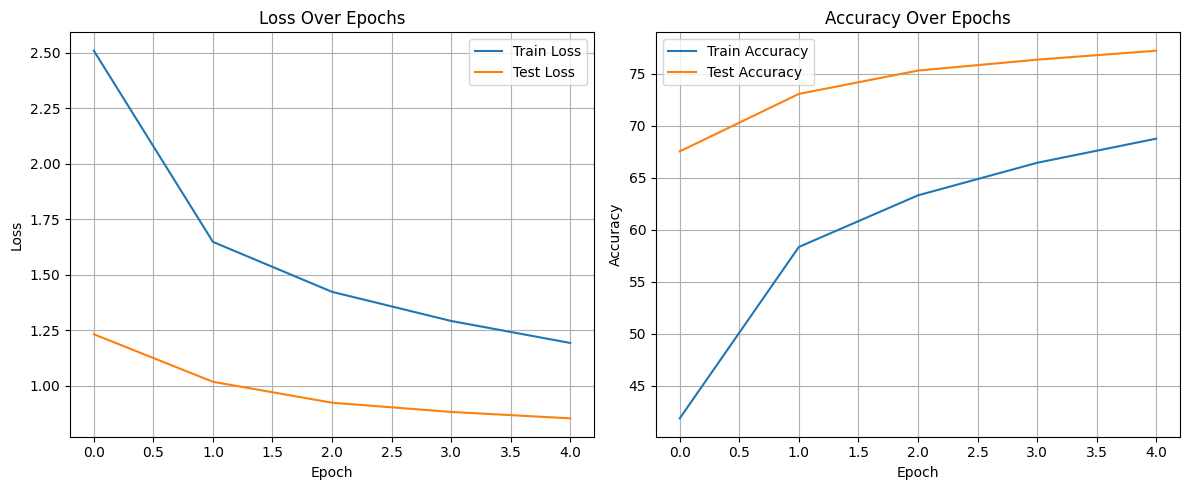

In [ ]:
plt.figure(figsize=(12, 5))

#plot Losses
plt.subplot(1, 2, 1)
plt.plot([i for i in range(num_epochs)], train_losses, label='Train Loss')
plt.plot([i for i in range(num_epochs)], test_losses, label='Test Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#plot Accuracies
plt.subplot(1, 2, 2)
plt.plot([i for i in range(num_epochs)], train_accs, label='Train Accuracy')
plt.plot([i for i in range(num_epochs)], test_accs, label='Test Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

#save figure
plt.savefig("Modeltraining.png", dpi=250)

plt.tight_layout()
plt.show()

Note that at first it might seem unintuive that Test accuracy is higher then training accuracy. However, this is quite normal as the test data is often (50% of time) augemnted and the model performs better on clean unaugmented data. In general our model learns reasonably **stable and fast**.

## Load the models
Load the presafed models as to **avoid having to retrain everytime the notebook is run**. This is particulary important considering I require a GPU to train the model (which for 5 epochs takes approx. 1 and a half hour on Colabs T4 GPU). However, the free GPU usage on Colab usually does not surfice to even train for 5 epochs, which is why saving and loading is so important.

In [18]:
#recreate the model architecture
basemodel = torchvision.models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
basemodel.classifier[1] = torch.nn.Linear(basemodel.classifier[1].in_features, 101)

#Helper function to load and return the model
def load_model(basemodel, accuracy):
  model = copy.deepcopy(basemodel)
  model.load_state_dict(torch.load(f"model_weights_accuracy_{accuracy}.pth", map_location=device))
  return model

#actually load the models
model_67_52 = load_model(basemodel, "67_52")
model_73_05 = load_model(basemodel, "73_05")
model_75_29 = load_model(basemodel, "75_29")
model_76_34 = load_model(basemodel, "76_34")
model_77_20 = load_model(basemodel, "77_20")

#set currently used model
current_model = model_77_20
current_model.to(device)
pass #to not print out the entire model everytime we run the to command


# Test - OOD Dection

This is the main focus of this project. In the following different OOD detection methods will be implemented and evaluated

## Dataset comparison
At first its always good to just get an overview with what kind of images we are dealing here.

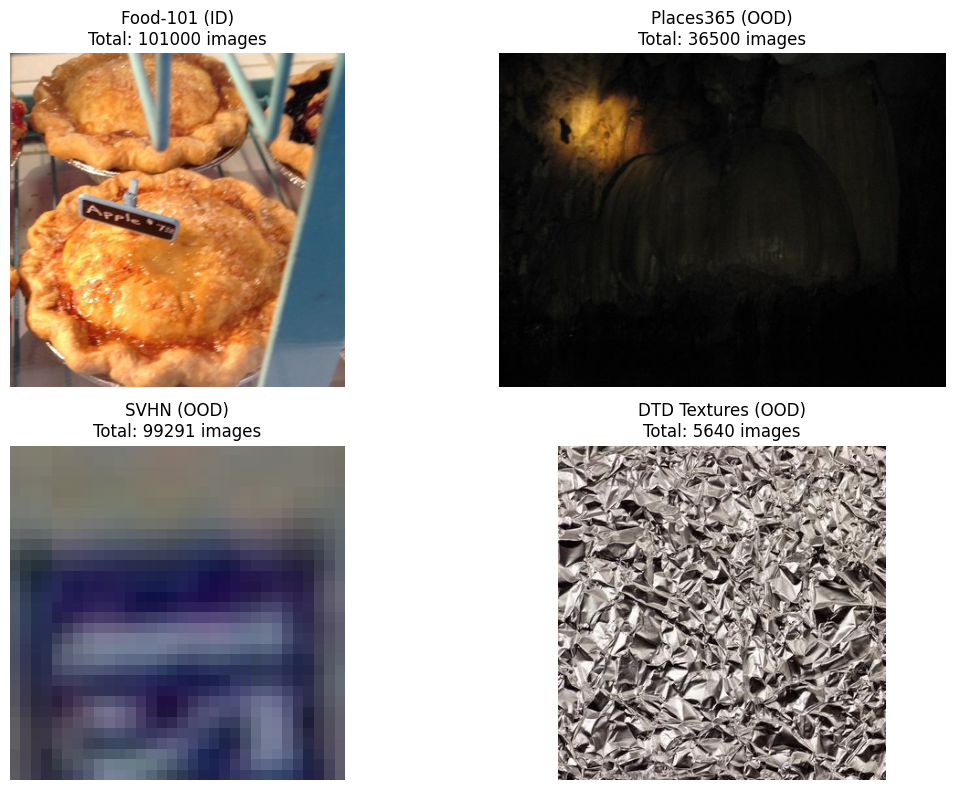

In [19]:
#define dataset paths as dictionary
datasets = {
    "Food-101 (ID)": "food-101/train/apple_pie",  #not really random but this is only a visualization
    "Places365 (OOD)": "place365",
    "SVHN (OOD)": "svhn",
    "DTD Textures (OOD)": "textures"
}

#Helper to count total number of images
def count_images(folder):
  return sum([len(files) for _, _, files in os.walk(folder)])

#create the plot
fig, axs = plt.subplots(2, 2, figsize=(12, 8)) #needs subplots
axs = axs.flatten() #flatten axis for easier access

#helper function to get a random image path from a dataset
def get_random_image_path(dataset_path):
  image_files = [f for f in os.listdir(dataset_path)]
  selected_image = random.choice(image_files)
  return os.path.join(dataset_path, selected_image)

#iterate over datasets
for i, (name, path) in enumerate(datasets.items()):
  img_path = get_random_image_path(path)
  img = Image.open(img_path).convert("RGB")

  axs[i].imshow(img)
  axs[i].axis("off")
  if not name== "Food-101 (ID)":
    axs[i].set_title(f"{name}\nTotal: {count_images(path)} images", fontsize=12)
  else:
    axs[i].set_title(f"{name}\nTotal: 101000 images", fontsize=12)

#save fig
plt.savefig("Dataset_comparison.png", dpi=250)

plt.tight_layout()
plt.show()

## Load the datasets

Create dataloaders for the OOD datasets. Additionally transform them, based on our predefined transformer.

In [20]:
#create a custom dataset for unlabeled data
class UnlabeledImageDataset(Dataset):

  #straight forward initialization
  def __init__(self, folder_path, transform=transform):
      self.transform = transform
      self.image_paths = [
          os.path.join(folder_path, f)
          for f in os.listdir(folder_path)
          if f.lower().endswith(('.jpg', '.jpeg', '.png'))
      ]

  def __len__(self):
      return len(self.image_paths)

  #only return the image (no label)
  def __getitem__(self, idx):
      img_path = self.image_paths[idx]
      image = Image.open(img_path).convert("RGB")
      if self.transform:
          image = self.transform(image)
      return image

In [21]:
#SVHN dataset
svhn_dataset = UnlabeledImageDataset("svhn", transform=transform)
svhn_loader = DataLoader(svhn_dataset, batch_size=test_batch_size, shuffle=True)

#Textures (DTD) dataset
dtd_dataset = UnlabeledImageDataset("textures", transform=transform)
dtd_loader = DataLoader(dtd_dataset, batch_size=test_batch_size, shuffle=True)

#Places365 dataset
places_dataset = UnlabeledImageDataset("place365", transform=transform)
places_loader = DataLoader(places_dataset, batch_size=test_batch_size, shuffle=True)

## Evaluation metrics

Contemporary research such as [Sharifi et al. (2024)](https://arxiv.org/pdf/2404.12368?) and [Tang et al. (2024)](https://openaccess.thecvf.com/content/CVPR2024/papers/Tang_CORES_Convolutional_Response-based_Score_for_Out-of-distribution_Detection_CVPR_2024_paper.pdf) tend to use two evaluation metrics for OOD detection, which both have the benefit of beeing threshold independent:

* **Area Under the Receiver Operating Characteristic Curve (AUROC)**: Measures how well the OOD detector separates ID from OOD across all possible thresholds by utilizing the ROC curve. A AUROC of 0.5 means the model guesses randomly while an AUROC score 1.0 signifies a perfect classification in OOD and ID.

* **False Positive Rate at 95% True Positive Rate (FPR95)**: Measures the false positive rate when the model correctly classifies 95% of ID data. The goal is to keep FPR95 as low as possible. The advantage of this metric is that it tends to be more practical as in reality we usually care about keeping the ID detection high while still wanting a low FPR.

Consequently in the remainder of this work these evaluation metrics will be deployed.

## Post-hoc methods

All methods implemented by me are post-hoc methods. This means the model does **not need to be exposed to OOD data during training**. It rather computes some form of score (based on the inputsample) which it uses to evaluate wheter the sample is ID or OOD. Given a score function S all methods determine a threshold $\delta$ and compute a function g that desides wheter a sample is ID or OOD based on the fromula:

$$
g(x) =
\begin{cases}
    \text{ID}, & \text{if } S(x)\geq \delta \\
    \text{OOD}, & \text{else}
\end{cases}
$$

## Baseline: Maximum Softmax Probability (MSP)
This baseline first described by [Hendrycks et al. (2017)](https://arxiv.org/pdf/1610.02136) will be used to test more advanced methods against. It simply works by getting the highest softmax confidence for each sample and from that calculating the distributions on ID and OOD dataset to determine a viable threshold.

### Helper function to evaluate MSP distribution

In [23]:
#helper function to evaluate a datasets distribution of softmax confidences
def evaluate_softmax_distribution(model, dataloader, max_images=1000):

  #set to evaluation mode
  model.eval()
  model.to(device)

  max_softmax_scores = []

  with torch.no_grad():

    processed_images = 0

    #iterate over images
    for batch in dataloader:

      #differentiate between dataloader with and without labels
      if isinstance(batch, (list, tuple)):
          images = batch[0]
      else:
          images = batch

      #break if we have gathered info on eneugh images (just for runtime if GPU is not available)
      if processed_images >= max_images:
        break

      #move to correct device
      images = images.to(device)

      #get the max softmax confidences for batch
      logits = model(images)
      softmax_probs = torch.nn.functional.softmax(logits, dim=1)
      max_probs, _ = torch.max(softmax_probs, dim=1)

      #add max softmax confidences to list
      max_softmax_scores.extend(max_probs.cpu().numpy())

      #add the number of processed images
      processed_images += len(images)

  return max_softmax_scores

#use test loader (model hasnt been learned on this data, also no augmentation)
softmax_scores_id = evaluate_softmax_distribution(current_model, test_loader)
softmax_scores_svhn = evaluate_softmax_distribution(current_model, svhn_loader)
softmax_scores_dtd = evaluate_softmax_distribution(current_model, dtd_loader)
softmax_scores_places = evaluate_softmax_distribution(current_model, places_loader)

### Evaluate MSP on data
For a clearer visualization I will also plot the resulting density plots. To mathematicaly get the optimal threshold one would use the Receiver Operating Characteristic (ROC) curve as described by [Hendrycks et al. (2017)](https://arxiv.org/pdf/1610.02136). Please note that the optimal threshold is not necessary to comput AUROC and FPR95 which are our evaluation metrics.

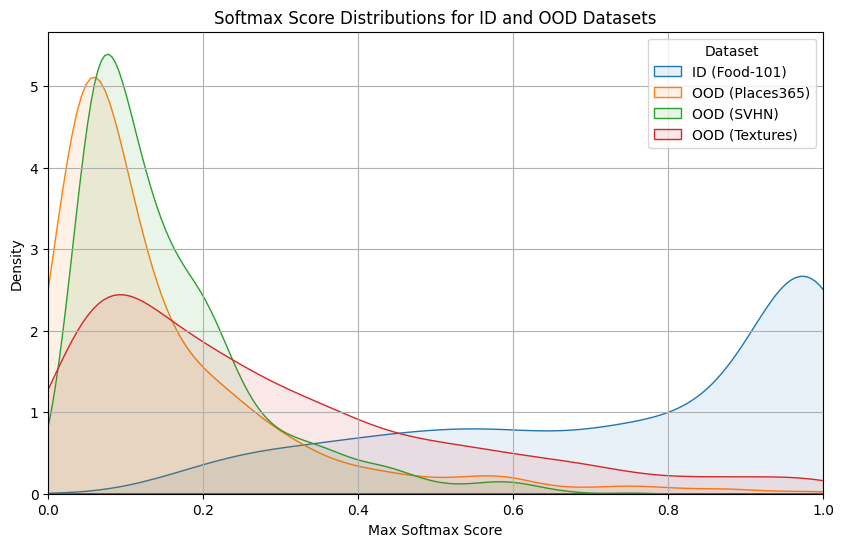

In [24]:
#create a list of all scores and their labels
all_softmax_scores = softmax_scores_id + softmax_scores_svhn + softmax_scores_dtd + softmax_scores_places
labels = (
    ['ID (Food-101)'] * len(softmax_scores_id) +
    ['OOD (SVHN)'] * len(softmax_scores_svhn) +
    ['OOD (Textures)'] * len(softmax_scores_dtd) +
    ['OOD (Places365)'] * len(softmax_scores_places)
)

#combine scores and labels into df for easier visualization
df = pd.DataFrame({
    "Score": all_softmax_scores,
    "Dataset": labels
})

#plot figure
plt.figure(figsize=(10, 6))
for name, group in df.groupby("Dataset"):
    sns.kdeplot(group["Score"], label=name, fill=True, alpha=0.1, common_norm=False) #need to manually iterate for legend

plt.xlabel('Max Softmax Score')
plt.ylabel('Density')
plt.title('Softmax Score Distributions for ID and OOD Datasets')
plt.xlim(0, 1) #limit to 0,1 as to not show impossible values (are visualized due to kde plotting)
plt.grid(True)
plt.legend(title="Dataset", loc="best")

#save figure
plt.savefig("MSP_density.png", dpi=250)

plt.show()

SVHN AUROC: 97.65
SVHN FPR@95TPR: 14.10


DTD AUROC: 90.07
DTD FPR@95TPR: 40.80


PLACES AUROC: 96.74
PLACES FPR@95TPR: 15.90


Optimal threshold: 0.3728
Combined AUROC: 94.82
Combined FPR95: 23.73


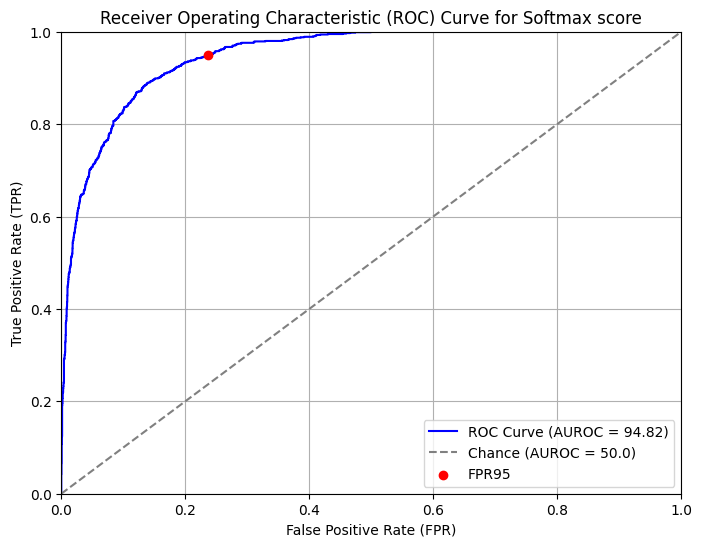

In [53]:
#Helper function to compute individual OOD scores
def compute_ood_metrics(id_scores, ood_scores, ood_name):

  #set up scores and labels
  all_scores = np.array(id_scores + ood_scores)
  labels = np.array([1] * len(id_scores) + [0] * len(ood_scores))

  #calculate ROC curve and AUROC
  fpr, tpr, thresholds = roc_curve(labels, all_scores)
  auroc = roc_auc_score(labels, all_scores)

  #find FPR when TPR is closest to 95%
  idx_95 = np.argmin(np.abs(tpr - 0.95))
  fpr95 = fpr[idx_95]

  print(f"{ood_name} AUROC: {auroc*100:.2f}")
  print(f"{ood_name} FPR@95TPR: {fpr95*100:.2f}")
  print("\n===================================================\n")

  return auroc, fpr95

# Individual evaluations
compute_ood_metrics(softmax_scores_id, softmax_scores_svhn, "SVHN")
compute_ood_metrics(softmax_scores_id, softmax_scores_dtd, "DTD")
compute_ood_metrics(softmax_scores_id, softmax_scores_places, "PLACES")

#For all of the OOD datasets togehter
softmax_scores_ood = softmax_scores_svhn + softmax_scores_dtd + softmax_scores_places

#combine scores
all_softmax_scores = np.array(softmax_scores_id + softmax_scores_ood)

#use indices to seperate ID and OOD data
labels = np.array([1] * len(softmax_scores_id) + [0] * len(softmax_scores_ood))  # 1=ID, 0=OOD

#compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_softmax_scores)

#compute Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

#find FPR when TPR is closest to 95%
target_tpr = 0.95
idx_95 = np.argmin(np.abs(tpr - target_tpr)) #get closest index
fpr95 = fpr[idx_95]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Combined AUROC: {roc_auc_score(labels, all_softmax_scores)*100:.2f}")
print(f"Combined FPR95: {fpr95*100:.2f}")

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUROC = {roc_auc_score(labels, all_softmax_scores)*100:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance (AUROC = 50.0)')
plt.scatter(fpr[np.argmin(np.abs(tpr - 0.95))], 0.95, color='red', label='FPR95', zorder=5)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Softmax score')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.savefig("MSP_ROC.png", dpi=250)

plt.show()

As we can see the result for our baselinemodel is already reasonably good (**AUROC=96.10**, **FPR95=17.15**). However lets see if we can improve these scores with different methods.

## Out-of-DIstribution detector for Neural networks (ODIN)

ODIN is an early post-hoc OOD method first introduced in the paper [Enhancing the Reliability of
Out-of-Distribution Image Detection in
Neural Networks (2018)](https://arxiv.org/pdf/1706.02690) by Liang et al. This method improves on the simple softmax confidence approach by adding **temperature scaling** and **input preprocessing** in which the softmax score of any given input is increased, without the
need for a class label at all.

Generally this method is not a completly novel approach but rather improves the softmax confidence score.

### Helper function to evaluate ODIN distribution

In [ ]:
#helper function to evaluate a datasets distribution of softmax confidences
def evaluate_odin_distribution(model, dataloader, max_images=1000, temp=10, eps=0.001):

  #set to evaluation mode
  model.eval()
  model.to(device)

  odin_scores = []

  processed_images = 0

  #iterate over images
  for batch in dataloader:

    #differentiate between dataloader with and without labels
    if isinstance(batch, (list, tuple)):
        images = batch[0]
    else:
        images = batch

    #break if we have gathered info on eneugh images (just for runtime if GPU is not available)
    if processed_images >= max_images:
      break

    #move to correct device
    images = images.to(device)

    #images need gradient --> we have to calc gradient of log(S_y(x; T))
    images.requires_grad = True

    #get the logits for batch
    logits = model(images)

    #scale the logits with temperature
    scaled_logits = logits/temp

    #get the predictions of the model
    softmax_probs = torch.nn.functional.softmax(scaled_logits, dim=1)
    max_probs, _ = torch.max(softmax_probs, dim=1)

    #compute log of selected softmax scores
    log_selected_probs = torch.log(max_probs)

    #set gradient to zero if it couldnt be calculated (should never be needed)
    if images.grad is not None:
      images.grad.zero_()

    #backward to compute gradient of log(S_y(x; T))
    log_selected_probs.sum().backward(retain_graph=False)

    #get signed gradient and create perturbation
    pertubation = -eps * images.grad.data.sign()

    #apply perturbation to input image
    pertubed_images = images + pertubation

    #get the max softmax confidences for pertubed batch
    with torch.no_grad():
      logits = model(pertubed_images)
      softmax_pertubed_probs = torch.nn.functional.softmax(logits, dim=1)
      max_pertubed_probs, _ = torch.max(softmax_pertubed_probs, dim=1)

    #add max softmax confidences to list
    odin_scores.extend(max_pertubed_probs.cpu().numpy())

    #add the number of processed images
    processed_images += len(images)

    #Images no longer need gradient
    images.requires_grad = False

  return odin_scores

#use test loader (model hasnt been learned on this data, also no augmentation)
odin_scores_id = evaluate_odin_distribution(current_model, test_loader)
odin_scores_svhn = evaluate_odin_distribution(current_model, svhn_loader)
odin_scores_dtd = evaluate_odin_distribution(current_model, dtd_loader)
odin_scores_places = evaluate_odin_distribution(current_model, places_loader)

### Evaluate ODIN on data
For a clearer visualization I will also plot the resulting ODIN score density plots.

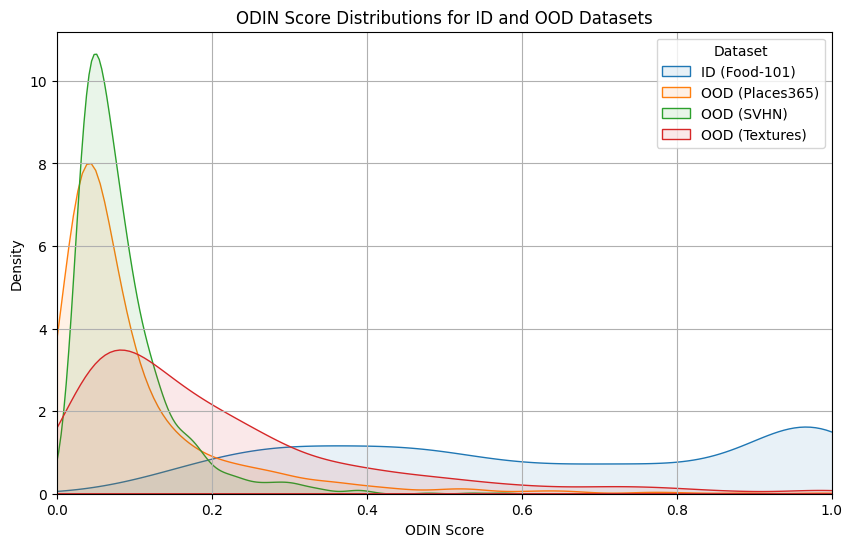

In [ ]:
#create a list of all scores and their labels
all_odin_scores = odin_scores_id + odin_scores_svhn + odin_scores_dtd + odin_scores_places
labels = (
    ['ID (Food-101)'] * len(odin_scores_id) +
    ['OOD (SVHN)'] * len(odin_scores_svhn) +
    ['OOD (Textures)'] * len(odin_scores_dtd) +
    ['OOD (Places365)'] * len(odin_scores_places)
)

#combine scores and labels into df
df = pd.DataFrame({
    "Score": all_odin_scores,
    "Dataset": labels
})

#plot figure
plt.figure(figsize=(10, 6))
for name, group in df.groupby("Dataset"):
    sns.kdeplot(group["Score"], label=name, fill=True, alpha=0.1, common_norm=False) #need to manually iterate for legend

plt.xlabel('ODIN Score')
plt.ylabel('Density')
plt.title('ODIN Score Distributions for ID and OOD Datasets')
plt.xlim(0, 1) #limit to 0,1 as to not show impossible values (are visualized due to kde plotting)
plt.grid(True)
plt.legend(title="Dataset", loc="best")
plt.savefig("ODIN_desnity.png", dpi=250)
plt.show()

SVHN AUROC: 98.66
SVHN FPR@95TPR: 6.00


DTD AUROC: 89.37
DTD FPR@95TPR: 39.50


PLACES AUROC: 96.78
PLACES FPR@95TPR: 13.30


Optimal threshold: 0.2115
Combined AUROC: 94.94
Combined FPR@95TPR: 19.60


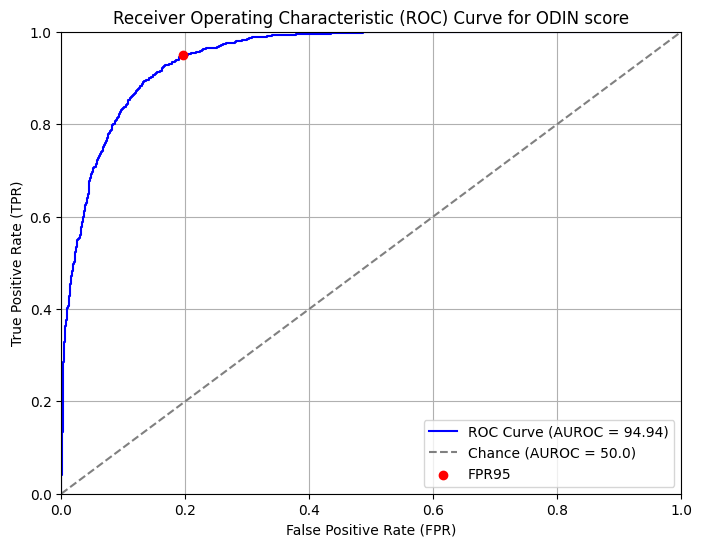

In [ ]:
#evaluate them individual --> reuse compute_ood_metrics function
compute_ood_metrics(odin_scores_id, odin_scores_svhn, "SVHN")
compute_ood_metrics(odin_scores_id, odin_scores_dtd, "DTD")
compute_ood_metrics(odin_scores_id, odin_scores_places, "PLACES")

#evaluate them combined
odin_scores_ood = odin_scores_svhn + odin_scores_dtd + odin_scores_places

#combine scores
all_odin_scores = np.array(odin_scores_id + odin_scores_ood)

#use indices to seperate ID and OOD data
labels = np.array([1] * len(odin_scores_id) + [0] * len(odin_scores_ood))  # 1=ID, 0=OOD

#compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_odin_scores)

#compute Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

#find FPR when TPR is closest to 95%
target_tpr = 0.95
idx_95 = np.argmin(np.abs(tpr - target_tpr)) #get closest index
fpr95 = fpr[idx_95]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Combined AUROC: {roc_auc_score(labels, all_odin_scores)*100:.2f}")
print(f"Combined FPR@95TPR: {fpr95*100:.2f}")

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUROC = {roc_auc_score(labels, all_odin_scores)*100:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance (AUROC = 50.0)')
plt.scatter(fpr[np.argmin(np.abs(tpr - 0.95))], 0.95, color='red', label='FPR95', zorder=5)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for ODIN score')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#save fig
plt.savefig("ODIN_ROC.png", dpi=250)

plt.show()

## Energy score
This method as described by [Liu et al. (2020)](https://proceedings.neurips.cc/paper/2020/file/f5496252609c43eb8a3d147ab9b9c006-Paper.pdf) utilizes a scalar energy score of raw logits to determine wheter a sample is ID or OOD, where a higher energy is common for ID Data. In the original paper another method to use energy bounded loss to augment the original loss function during training was suggested as well. However this method requires knowing OOD samples during training and is thus not a post-hoc method. Thus I decided not to use it in this project.

### Helper function to evaluate Energyscore distribution

In [26]:
#helper function to evaluate a datasets distribution of energy scalars
def evaluate_energy_distribution(model, dataloader, temp=10, max_images=1000):

  #set to evaluation mode
  model.eval()
  model.to(device)

  energy_scores = []

  with torch.no_grad():

    processed_images = 0

    #iterate over images
    for batch in dataloader:

      #differentiate between dataloader with and without labels
      if isinstance(batch, (list, tuple)):
          images = batch[0]
      else:
          images = batch

      #break if we have gathered info on eneugh images (just for runtime if GPU is not available)
      if processed_images >= max_images:
        break

      #move to correct device
      images = images.to(device)

      #get the energy of batch --> no normalization required (see paper)
      logits = model(images)
      energy = -temp*torch.logsumexp(logits/temp, dim=1)

      #add max softmax confidences to list
      energy_scores.extend(energy.cpu().numpy())

      #add the number of processed images
      processed_images += len(images)

  return energy_scores

#use test loader (model hasnt been learned on this data, also no augmentation)
energy_scores_id = evaluate_energy_distribution(current_model, test_loader)
energy_scores_svhn = evaluate_energy_distribution(current_model, svhn_loader)
energy_scores_dtd = evaluate_energy_distribution(current_model, dtd_loader)
energy_scores_places = evaluate_energy_distribution(current_model, places_loader)

### Evaluate Energyscore on data
For a clearer visualization I will also plot the resulting energy density plots.

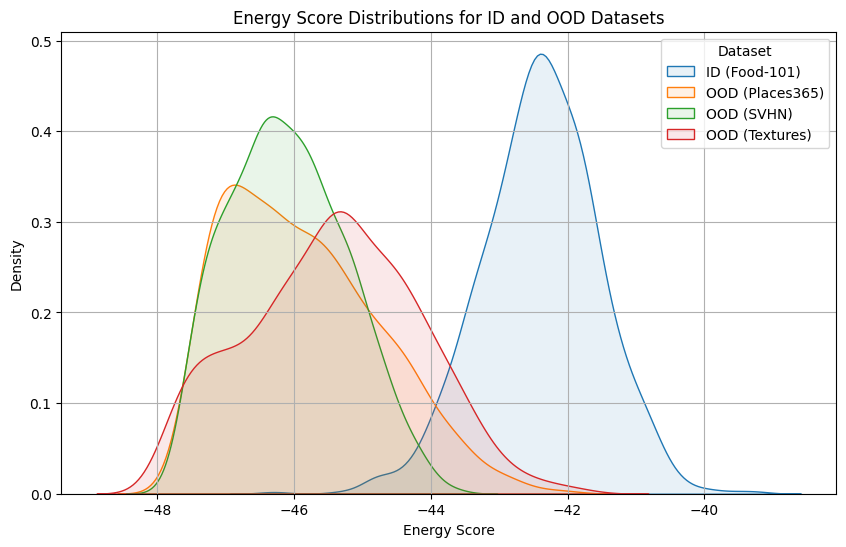

In [27]:
#create a list of all scores and their labels
all_energy_scores = energy_scores_id + energy_scores_svhn + energy_scores_dtd + energy_scores_places
labels = (
    ['ID (Food-101)'] * len(energy_scores_id) +
    ['OOD (SVHN)'] * len(energy_scores_svhn) +
    ['OOD (Textures)'] * len(energy_scores_dtd) +
    ['OOD (Places365)'] * len(energy_scores_places)
)

#combine scores and labels into df
df = pd.DataFrame({
    "Score": all_energy_scores,
    "Dataset": labels
})

#plot figure
plt.figure(figsize=(10, 6))
for name, group in df.groupby("Dataset"):
    sns.kdeplot(group["Score"], label=name, fill=True, alpha=0.1, common_norm=False) #need to manually iterate for legend

plt.xlabel('Energy Score')
plt.ylabel('Density')
plt.title('Energy Score Distributions for ID and OOD Datasets')
plt.grid(True)
plt.legend(title="Dataset", loc="best")

#save fig
plt.savefig("Energy_desnity.png", dpi=250)

plt.show()

We can already see in this visualization that the ID data tends to have a lower energy score than the OOD samples.

SVHN AUROC: 99.81
SVHN FPR@95TPR: 0.20


DTD AUROC: 97.75
DTD FPR@95TPR: 10.00


PLACES AUROC: 98.88
PLACES FPR@95TPR: 4.90


Optimal threshold: 43.9622
Combined AUROC: 98.82
Combined FPR@95TPR: 5.03


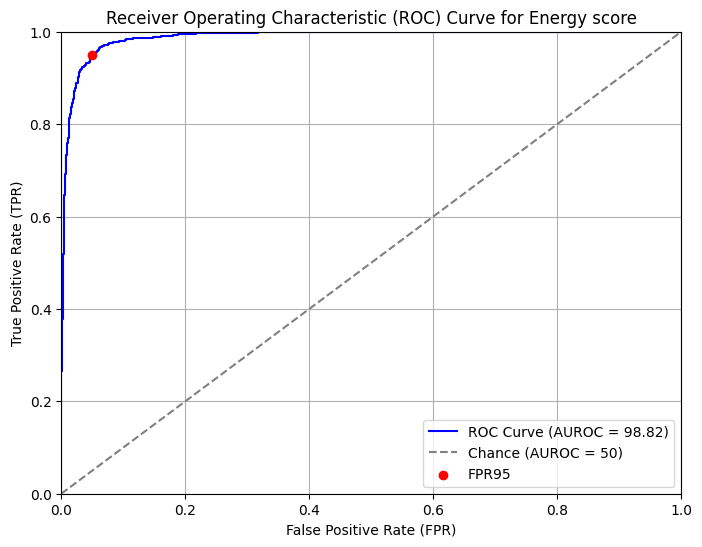

In [57]:
#evaluate them individual --> reuse compute_ood_metrics function
compute_ood_metrics(energy_scores_id, energy_scores_svhn, "SVHN")
compute_ood_metrics(energy_scores_id, energy_scores_dtd, "DTD")
compute_ood_metrics(energy_scores_id, energy_scores_places, "PLACES")

#evaluate on all of them together
energy_scores_ood = energy_scores_svhn + energy_scores_dtd + energy_scores_places

#combine scores
all_energy_scores = np.array(energy_scores_id + energy_scores_ood)

#use indices to seperate ID and OOD data
labels = np.array([1] * len(energy_scores_id) + [0] * len(energy_scores_ood))  # 1=ID, 0=OOD

#compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_energy_scores) #we need to invert here

#compute Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = -thresholds[optimal_idx]

#find FPR when TPR is closest to 95%
target_tpr = 0.95
idx_95 = np.argmin(np.abs(tpr - target_tpr)) #get closest index
fpr95 = fpr[idx_95]

print(f"Optimal threshold: {optimal_threshold:.4f}")
print(f"Combined AUROC: {roc_auc_score(labels, all_energy_scores)*100:.2f}")
print(f"Combined FPR@95TPR: {fpr95*100:.2f}")

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUROC = {roc_auc_score(labels, all_energy_scores)*100:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance (AUROC = 50)')
plt.scatter(fpr[np.argmin(np.abs(tpr - 0.95))],0.95, color='red', label='FPR95', zorder=5)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Energy score')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#save the figure
plt.savefig("Energy_ROC.png", dpi=250)

plt.show()

## GradNorm

This method first introduced in the paper [On the Importance of Gradients for Detecting
Distributional Shifts in the Wild (2021)](https://proceedings.neurips.cc/paper_files/paper/2021/file/063e26c670d07bb7c4d30e6fc69fe056-Paper.pdf) by Huang et al. utilizes information in the gradient of the KL-Divergence between output logits and a uniform distribution. Specifically it uses the fact that the gradients tend to be higher for ID samples, as the KL-divergence is higher as well.


### Helper function to evaluate GradNorm distribution

In [ ]:
#helper function to evaluate a datasets distribution of gradnorm scores
def evaluate_gradnorm_distribution(model, dataloader, max_images=1000):

  #The KL convergence between uniform dist and softmax logits is equivalent to the average of the cross entropy loss over all labels

  #Create uniform distribution over labels
  uniform_dist = torch.full((101,), 1/101)
  uniform_dist = uniform_dist.to(device)

  #set to evaluation mode
  model.eval()
  model.to(device)

  grad_norms = []

  processed_images = 0

  #iterate over images
  for batch in dataloader:

    #differentiate between dataloader with and without labels
    if isinstance(batch, (list, tuple)):
        images = batch[0]
    else:
        images = batch

    #break if we have gathered info on eneugh images (just for runtime if GPU is not available)
    if processed_images >= max_images:
      break

    #move to correct device
    images = images.to(device)

    #set require grad to true
    images.requires_grad = True
    images.grad = None

    #clear previous gradients
    model.zero_grad()

    #get the softmax probabilites from the batch
    logits = model(images)
    softmax_probs = torch.nn.functional.softmax(logits, dim=1)
    log_probs = torch.log(softmax_probs + 1e-10) #adding small value makes it more stable

    #calculate kl divergence
    kl_divs = torch.nn.functional.kl_div(log_probs, uniform_dist, reduction='batchmean')


    #backpropagate to get gradients
    kl_divs.backward()

    # collect gradients and compute global grad norm
    total_norm = 0.0
    for p in model.parameters():
      if p.grad is not None:
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2

    total_norm = total_norm ** 0.5  # L2 norm of all grads

    #add gradnorm score to list
    grad_norms.append(total_norm)

    #add the number of processed images
    processed_images += len(images)

  return grad_norms

#use test loader (model hasnt been learned on this data, also no augmentation)
gradnorm_scores_id = evaluate_gradnorm_distribution(current_model, test_loader)
gradnorm_scores_svhn = evaluate_gradnorm_distribution(current_model, svhn_loader)
gradnorm_scores_dtd = evaluate_gradnorm_distribution(current_model, dtd_loader)
gradnorm_scores_places = evaluate_gradnorm_distribution(current_model, places_loader)

### Evaluate GradNorm on data
For a clearer visualization I will plot the density of gradNorms over all datasets

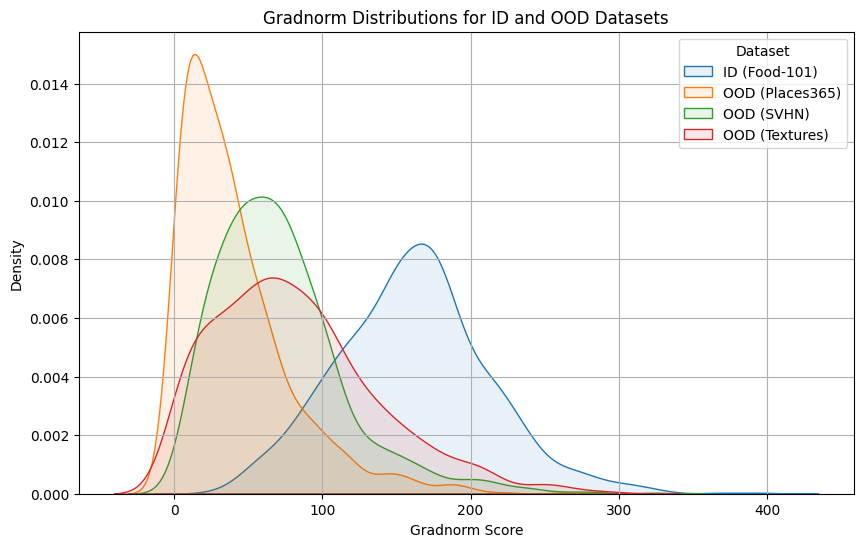

In [ ]:
#create a list of all scores and their labels
all_gradnorm_scores = gradnorm_scores_id + gradnorm_scores_svhn + gradnorm_scores_dtd + gradnorm_scores_places
labels = (
    ['ID (Food-101)'] * len(gradnorm_scores_id) +
    ['OOD (SVHN)'] * len(gradnorm_scores_svhn) +
    ['OOD (Textures)'] * len(gradnorm_scores_dtd) +
    ['OOD (Places365)'] * len(gradnorm_scores_places)
)

#combine scores and labels into df
df = pd.DataFrame({
    "Score": all_gradnorm_scores,
    "Dataset": labels
})

#plot figure
plt.figure(figsize=(10, 6))
for name, group in df.groupby("Dataset"):
    sns.kdeplot(group["Score"], label=name, fill=True, alpha=0.1, common_norm=False) #need to manually iterate for legend

plt.xlabel('Gradnorm Score')
plt.ylabel('Density')
plt.title('Gradnorm Distributions for ID and OOD Datasets')
plt.grid(True)
plt.legend(title="Dataset", loc="best")

#save the figure
plt.savefig("Gradnorm_density.png", dpi=250)

plt.show()

SVHN AUROC: 91.01
SVHN FPR@95TPR: 34.40


DTD AUROC: 85.66
DTD FPR@95TPR: 46.00


PLACES AUROC: 96.49
PLACES FPR@95TPR: 13.10


Optimal threshold: 103.0742
Combined AUROC: 91.05
Combined FPR@95TPR: 31.17


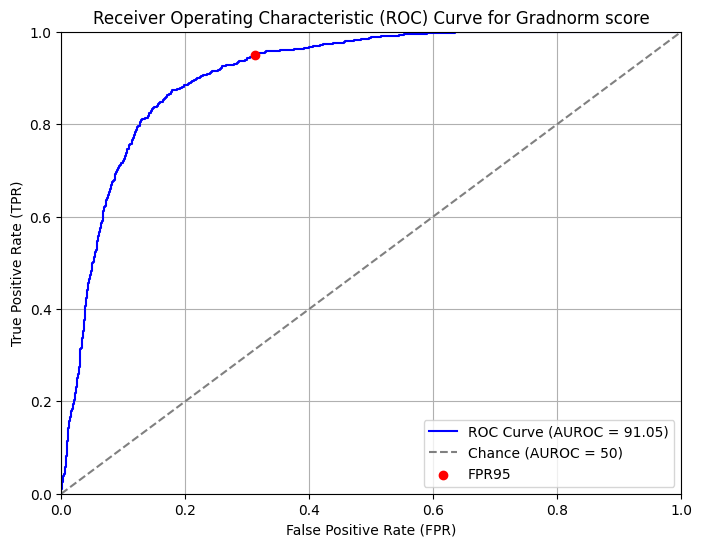

In [ ]:
#evaluate them individual --> reuse compute_ood_metrics function
compute_ood_metrics(gradnorm_scores_id, gradnorm_scores_svhn, "SVHN")
compute_ood_metrics(gradnorm_scores_id, gradnorm_scores_dtd, "DTD")
compute_ood_metrics(gradnorm_scores_id, gradnorm_scores_places, "PLACES")

#evaluate on all of them together
gradnorm_scores_ood = gradnorm_scores_svhn + gradnorm_scores_dtd + gradnorm_scores_places

#combine scores
all_gradnorm_scores = np.array(gradnorm_scores_id + gradnorm_scores_ood)

#use indices to seperate ID and OOD data
labels = np.array([1] * len(gradnorm_scores_id) + [0] * len(gradnorm_scores_ood))  # 1=ID, 0=OOD

#compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_gradnorm_scores)

#compute Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = -thresholds[optimal_idx]

#find FPR when TPR is closest to 95%
target_tpr = 0.95
idx_95 = np.argmin(np.abs(tpr - target_tpr)) #get closest index
fpr95 = fpr[idx_95]

print(f"Optimal threshold: {-optimal_threshold:.4f}")
print(f"Combined AUROC: {roc_auc_score(labels, all_gradnorm_scores)*100:.2f}")
print(f"Combined FPR@95TPR: {fpr95*100:.2f}")

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUROC = {roc_auc_score(labels, all_gradnorm_scores)*100:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance (AUROC = 50)')
plt.scatter(fpr[np.argmin(np.abs(tpr - 0.95))], 0.95, color='red', label='FPR95', zorder=5)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradnorm score')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.savefig("Gradnorm_ROC.png", dpi=250)
plt.show()

## FeatureNorm

This method first described in the paper [Reducing Network Agnostophobia (2018)](https://proceedings.neurips.cc/paper/2018/file/48db71587df6c7c442e5b76cc723169a-Paper.pdf) by Dhamija et al. utilizes the norm of deep feature vectors to differentiate between ID and OOD samples. While in the original paper they retrained the model on predefined Entropic Open-Set or Objectosphere losses, there exists modern versions of this approach that works post-hoc. Specifically we can use the L2-norm of the last feature vector before the final layer to calculate a score.

### Helper function to calculate FeatureNorm distribution

In [ ]:
#helper function to evaluate a datasets distribution of energy scalars
def evaluate_featurenorm_distribution(model, dataloader, max_images=600):

  #set to evaluation mode
  model.eval()
  model.to(device)

  #get the model but remove the last FC layer
  feature_extractor = nn.Sequential(*list(model.children())[:-1])

  feature_norms = []

  processed_images = 0

  with torch.no_grad():

    #iterate over images
    for batch in dataloader:

      #differentiate between dataloader with and without labels
      if isinstance(batch, (list, tuple)):
          images = batch[0]
      else:
          images = batch

      #break if we have gathered info on eneugh images (just for runtime if GPU is not available)
      if processed_images >= max_images:
        break

      #move to correct device
      images = images.to(device)

      #extract the feature space of the last layer
      features = feature_extractor(images)

      #flatten to be able to calulate the norm
      features = torch.flatten(features, 1)

      #calculate the norm of the features
      feature_norm = torch.norm(features, p=2, dim=1)

      #add feature_norm to list
      feature_norms.extend(feature_norm.cpu().numpy())

      #add the number of processed images
      processed_images += len(images)

  return feature_norms

#use test loader (model hasnt been learned on this data, also no augmentation)
featurenorm_scores_id = evaluate_featurenorm_distribution(current_model, test_loader)
featurenorm_scores_svhn = evaluate_featurenorm_distribution(current_model, svhn_loader)
featurenorm_scores_dtd = evaluate_featurenorm_distribution(current_model, dtd_loader)
featurenorm_scores_places = evaluate_featurenorm_distribution(current_model, places_loader)

### Evaluate FeatureNorm on data
For a clearer visualization I will plot the density of FeatureNorms over all datasets

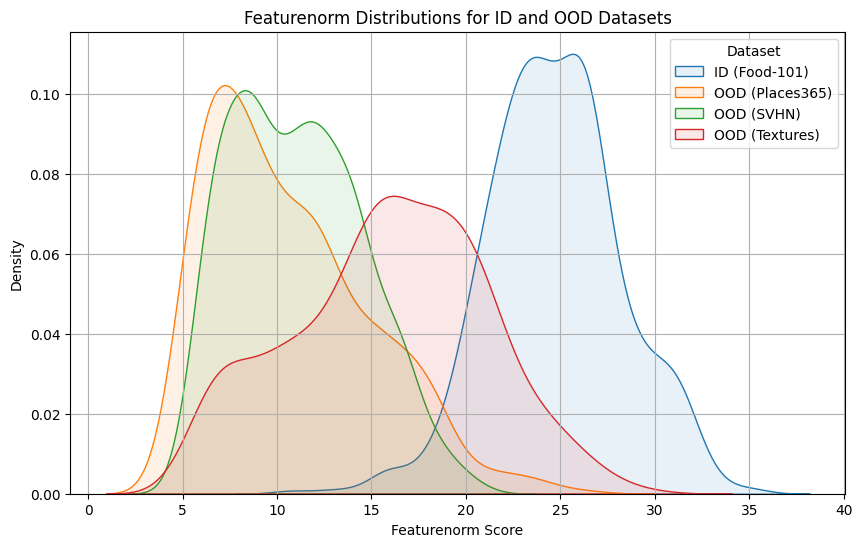

In [ ]:
#create a list of all scores and their labels
all_featurenorm_scores = featurenorm_scores_id + featurenorm_scores_svhn + featurenorm_scores_dtd + featurenorm_scores_places
labels = (
    ['ID (Food-101)'] * len(featurenorm_scores_id) +
    ['OOD (SVHN)'] * len(featurenorm_scores_svhn) +
    ['OOD (Textures)'] * len(featurenorm_scores_dtd) +
    ['OOD (Places365)'] * len(featurenorm_scores_places)
)

#combine scores and labels into df
df = pd.DataFrame({
    "Score": all_featurenorm_scores,
    "Dataset": labels
})

#plot figure
plt.figure(figsize=(10, 6))
for name, group in df.groupby("Dataset"):
    sns.kdeplot(group["Score"], label=name, fill=True, alpha=0.1, common_norm=False) #need to manually iterate for legend

plt.xlabel('Featurenorm Score')
plt.ylabel('Density')
plt.title('Featurenorm Distributions for ID and OOD Datasets')
plt.grid(True)
plt.legend(title="Dataset", loc="best")

#save fig
plt.savefig("Featurenorm_density.png", dpi=250)

plt.show()

SVHN AUROC: 99.61
SVHN FPR@95TPR: 0.83


DTD AUROC: 92.68
DTD FPR@95TPR: 26.17


PLACES AUROC: 98.88
PLACES FPR@95TPR: 2.67


Optimal threshold: 19.3787
Combined AUROC: 97.06
Combined FPR@95TPR: 9.94


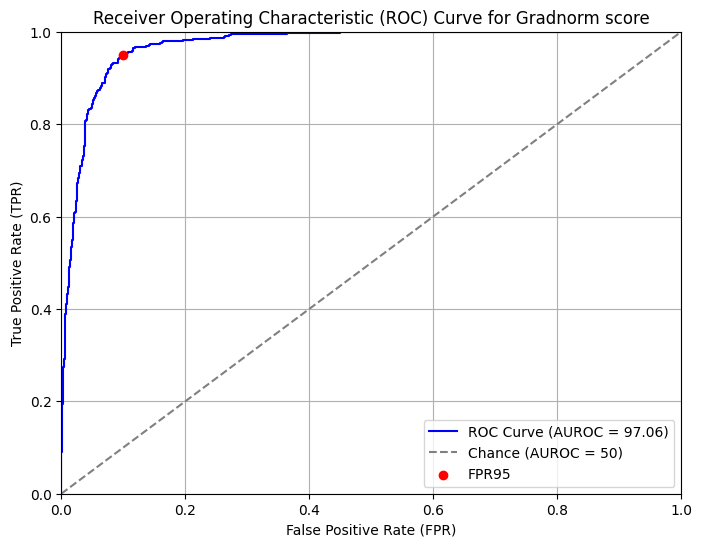

In [ ]:
#evaluate them individual --> reuse compute_ood_metrics function
compute_ood_metrics(featurenorm_scores_id, featurenorm_scores_svhn, "SVHN")
compute_ood_metrics(featurenorm_scores_id, featurenorm_scores_dtd, "DTD")
compute_ood_metrics(featurenorm_scores_id, featurenorm_scores_places, "PLACES")

#evaluate on all of them together
featurenorm_scores_ood = featurenorm_scores_svhn + featurenorm_scores_dtd + featurenorm_scores_places

#combine scores
all_featurenorm_scores = np.array(featurenorm_scores_id + featurenorm_scores_ood)

#use indices to seperate ID and OOD data
labels = np.array([1] * len(featurenorm_scores_id) + [0] * len(featurenorm_scores_ood))  # 1=ID, 0=OOD

#compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_featurenorm_scores) #we need to invert here

#compute Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = -thresholds[optimal_idx]

#find FPR when TPR is closest to 95%
target_tpr = 0.95
idx_95 = np.argmin(np.abs(tpr - target_tpr)) #get closest index
fpr95 = fpr[idx_95]

print(f"Optimal threshold: {-optimal_threshold:.4f}")
print(f"Combined AUROC: {roc_auc_score(labels, all_featurenorm_scores)*100:.2f}")
print(f"Combined FPR@95TPR: {fpr95*100:.2f}")

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUROC = {roc_auc_score(labels, all_featurenorm_scores)*100:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Chance (AUROC = 50)')
plt.scatter(fpr[np.argmin(np.abs(tpr - 0.95))], 0.95, color='red', label='FPR95', zorder=5)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Gradnorm score')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

#save fig
plt.savefig("Featurenorm_ROC.png", dpi=250)

plt.show()

## Discussion of OOD-Detection results

In the given setting the **Energy score** (with temperature tuning) seems to work best (i.e. it has lowest FPR95 and highest AUROC) on most datasets. It is interesting to mention that using a different temperature (e.g. 1) it drops to being the worst of the OOD-Detection methods examined.

Another key finding is that FeatureNorm works better on the Places365 dataset signifying that theres **no universal best method** but it much rather depends on dataset and model.


## OOD detection with different model accuracys

The goal of this small section is to find out wheter the quality of OOD detection differs based on model accuracy. Luckily we already saved intermediate model weights during training and thus have a range of model accuracys to work with.

In [43]:
#collect all saved models
all_models = [model_67_52, model_73_05, model_75_29, model_76_34, model_77_20]
accuracy_list = [67.52, 73.05, 75.29, 76.34, 77.20]

#set max_images --> tradeoff between runtime and accuracy
max_images = 700

### Helper function to calculate and plot metrics over model accuracy

In [59]:
def model_accuracy_difference(eval_method, name_eval_method, max_images = max_images):
  #create dictionary with form {model: scores_id, scores_ood}
  model_dict = {}

  #create list for AUROC and FPR95 scores
  auroc_list = []
  fpr_list = []

  #iterate through all model lists
  for model in all_models:

    #evaluate MSP
    softmax_scores_id = eval_method(model, test_loader, max_images=max_images)
    softmax_scores_svhn = eval_method(model, svhn_loader, max_images=max_images)
    softmax_scores_dtd = eval_method(model, dtd_loader, max_images=max_images)
    softmax_scores_places = eval_method(model, places_loader, max_images=max_images)

    #update the dictionary
    model_dict.update({model: (softmax_scores_id, softmax_scores_svhn + softmax_scores_dtd + softmax_scores_places)})

  #iterate over dictionary
  for i, (model, (scores_id, scores_ood)) in enumerate(model_dict.items()):

    #compute AUROC and FPR95
    auroc, fpr95 = compute_ood_metrics(scores_id, scores_ood, f"Modelaccuracy {accuracy_list[i]} using {name_eval_method}")
    auroc_list.append(auroc)
    fpr_list.append(fpr95)

  #visualize auroc and fpr with model accuracy
  plt.figure(figsize=(10, 6))
  plt.plot(accuracy_list, auroc_list, marker='o', linestyle='-', color='b', label='AUROC')
  plt.plot(accuracy_list, fpr_list, marker='o', linestyle='-', color='r', label='FPR95')
  plt.grid()
  plt.title(f"{name_eval_method} over model accuracy")
  plt.xlabel("Model accuracy")
  plt.ylabel("AUROC/FPR95")
  plt.legend(loc="best")

  #save fig
  plt.savefig(f"{name_eval_method}_over_modelaccuracy.png", dpi=250)

  plt.show()

### Model accuracy differences - MSP

Modelaccuracy 67.52 using MSP AUROC: 94.41
Modelaccuracy 67.52 using MSP FPR@95TPR: 18.90


Modelaccuracy 73.05 using MSP AUROC: 92.34
Modelaccuracy 73.05 using MSP FPR@95TPR: 29.86


Modelaccuracy 75.29 using MSP AUROC: 92.54
Modelaccuracy 75.29 using MSP FPR@95TPR: 29.90


Modelaccuracy 76.34 using MSP AUROC: 95.42
Modelaccuracy 76.34 using MSP FPR@95TPR: 18.71


Modelaccuracy 77.2 using MSP AUROC: 94.96
Modelaccuracy 77.2 using MSP FPR@95TPR: 23.95




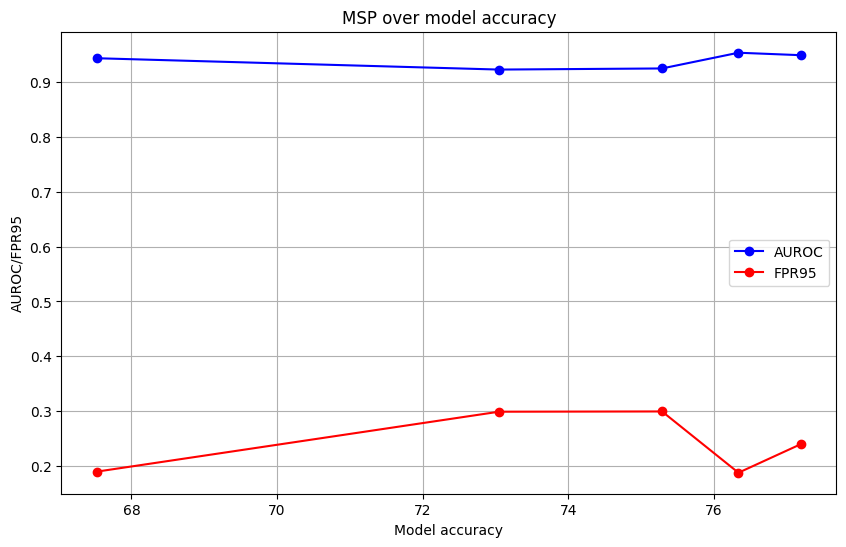

In [ ]:
model_accuracy_difference(evaluate_softmax_distribution, "MSP")

### Model accuracy difference - ODIN

Modelaccuracy 67.52 using ODIN AUROC: 94.48
Modelaccuracy 67.52 using ODIN FPR@95TPR: 19.10


Modelaccuracy 73.05 using ODIN AUROC: 93.83
Modelaccuracy 73.05 using ODIN FPR@95TPR: 24.05


Modelaccuracy 75.29 using ODIN AUROC: 94.11
Modelaccuracy 75.29 using ODIN FPR@95TPR: 22.90


Modelaccuracy 76.34 using ODIN AUROC: 96.20
Modelaccuracy 76.34 using ODIN FPR@95TPR: 13.95


Modelaccuracy 77.2 using ODIN AUROC: 95.29
Modelaccuracy 77.2 using ODIN FPR@95TPR: 17.10




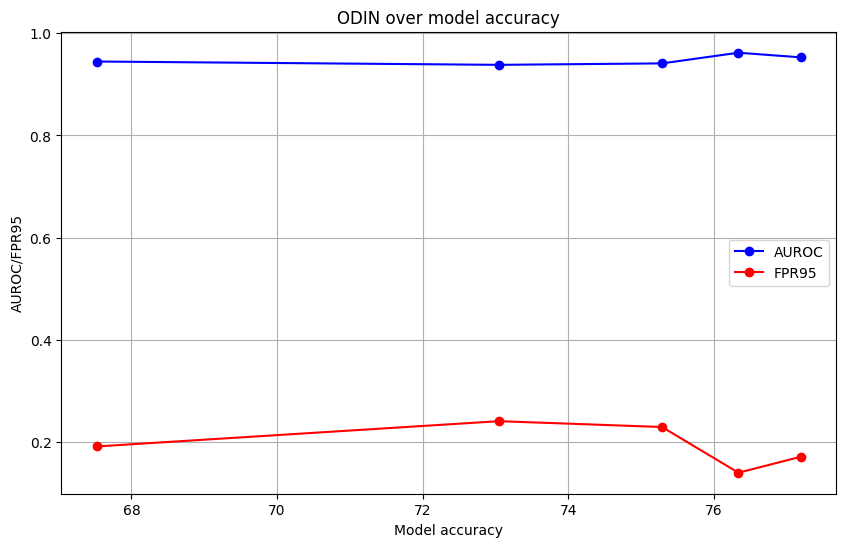

In [ ]:
model_accuracy_difference(evaluate_odin_distribution, "ODIN")

### Model accuracy difference - Energy

Modelaccuracy 67.52 using Energy AUROC: 98.96
Modelaccuracy 67.52 using Energy FPR@95TPR: 4.14


Modelaccuracy 73.05 using Energy AUROC: 98.88
Modelaccuracy 73.05 using Energy FPR@95TPR: 5.00


Modelaccuracy 75.29 using Energy AUROC: 98.83
Modelaccuracy 75.29 using Energy FPR@95TPR: 4.52


Modelaccuracy 76.34 using Energy AUROC: 99.14
Modelaccuracy 76.34 using Energy FPR@95TPR: 3.19


Modelaccuracy 77.2 using Energy AUROC: 98.91
Modelaccuracy 77.2 using Energy FPR@95TPR: 4.38




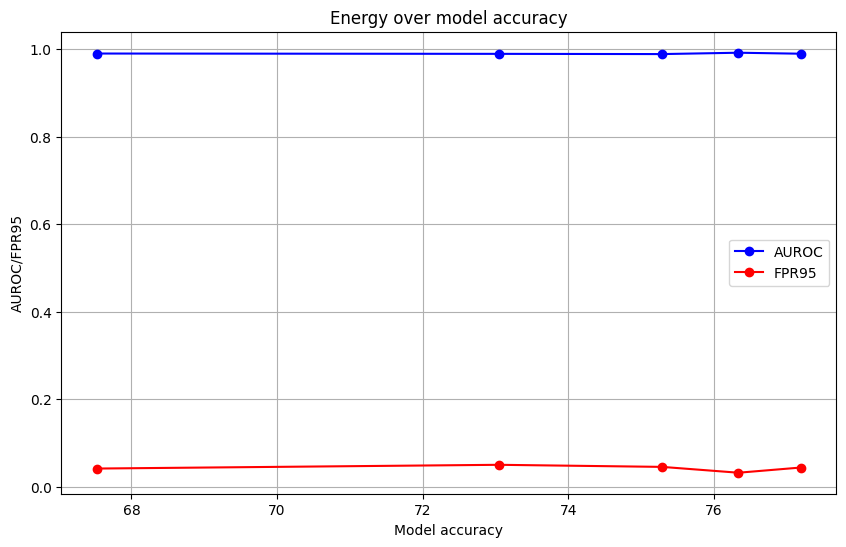

In [60]:
model_accuracy_difference(evaluate_energy_distribution, "Energy")

### Model accuracy difference - GradNorm

Modelaccuracy 67.52 using GradNorm AUROC: 90.97
Modelaccuracy 67.52 using GradNorm FPR@95TPR: 34.48


Modelaccuracy 73.05 using GradNorm AUROC: 88.85
Modelaccuracy 73.05 using GradNorm FPR@95TPR: 34.19


Modelaccuracy 75.29 using GradNorm AUROC: 87.10
Modelaccuracy 75.29 using GradNorm FPR@95TPR: 40.81


Modelaccuracy 76.34 using GradNorm AUROC: 91.50
Modelaccuracy 76.34 using GradNorm FPR@95TPR: 27.67


Modelaccuracy 77.2 using GradNorm AUROC: 91.53
Modelaccuracy 77.2 using GradNorm FPR@95TPR: 28.19




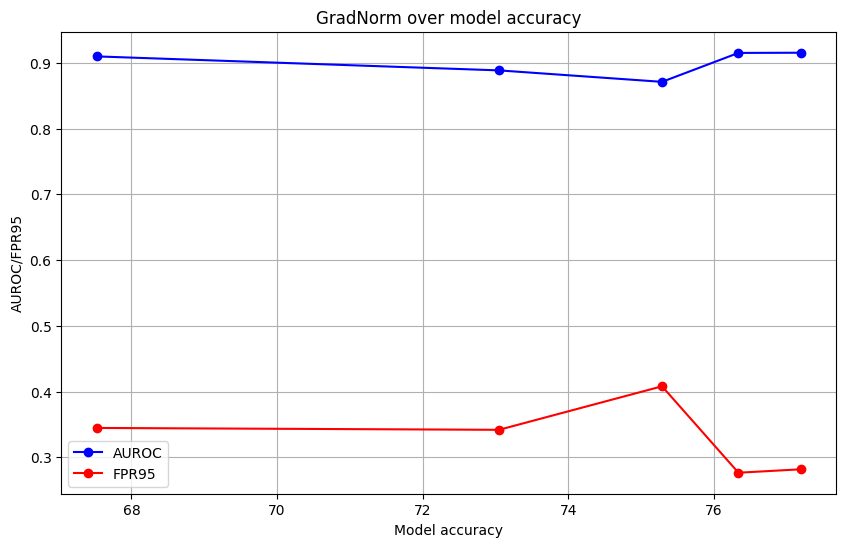

In [ ]:
model_accuracy_difference(evaluate_gradnorm_distribution, "GradNorm")

### Model accuracy difference - FeatureNorm


Modelaccuracy 67.52 using FeatureNorm AUROC: 96.97
Modelaccuracy 67.52 using FeatureNorm FPR@95TPR: 11.71


Modelaccuracy 73.05 using FeatureNorm AUROC: 96.02
Modelaccuracy 73.05 using FeatureNorm FPR@95TPR: 12.14


Modelaccuracy 75.29 using FeatureNorm AUROC: 96.89
Modelaccuracy 75.29 using FeatureNorm FPR@95TPR: 9.57


Modelaccuracy 76.34 using FeatureNorm AUROC: 98.35
Modelaccuracy 76.34 using FeatureNorm FPR@95TPR: 6.71


Modelaccuracy 77.2 using FeatureNorm AUROC: 97.08
Modelaccuracy 77.2 using FeatureNorm FPR@95TPR: 10.14




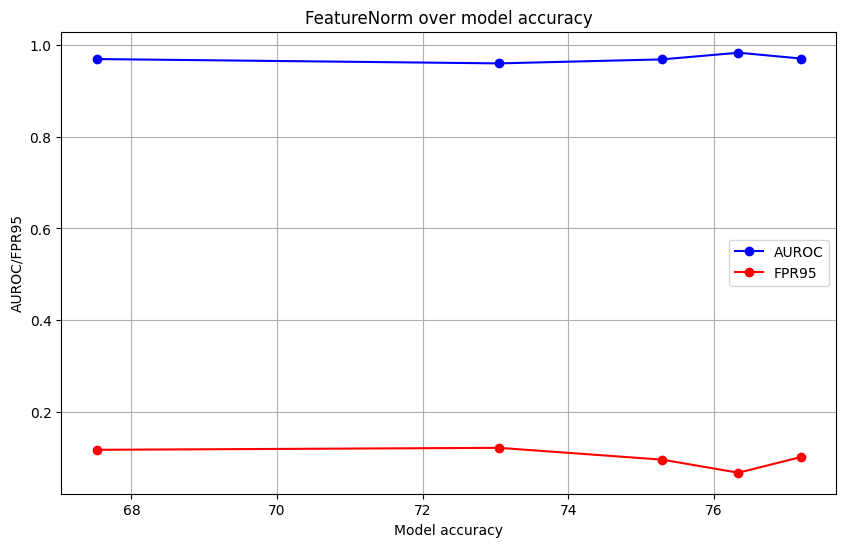

In [ ]:
model_accuracy_difference(evaluate_featurenorm_distribution, "FeatureNorm")

## Discussion of results for OOD-Metrics on different model accuracys

In general there doesn't seem to be **no significant change in performance for different OOD-Detection methods based on model accuracy**. However these findings are severly **limited by** me only being able to use a **small amount of samples** (700) per dataset per model accuracy. Also the **range of different model accuracys is quite small**. In future works it might thus be interesting to use a larger amount of samples for evaluation as well as to use a more diverse range of models regarding their top-1 accuracy.